### Project :: Evolution Strategies

![img](https://t4.ftcdn.net/jpg/00/17/46/81/240_F_17468143_wY3hsHyfNYoMdG9BlC56HI4JA7pNu63h.jpg)

Remember the idea behind Evolution Strategies? Here's a neat [blog post](https://blog.openai.com/evolution-strategies/) about 'em.

Can you reproduce their success? You will have to implement evolutionary strategies and see how they work.

This project is optional; has several milestones each worth a number of points [and swag].

__Milestones:__
* [10pts] Basic prototype of evolutionary strategies that works in one thread on CartPole
* [+5pts] Modify the code to make them work in parallel
* [+5pts] if you can run ES distributedly on at least two PCs
* [+10pts] Apply ES to play Atari Pong at least better than random
* [++] Additional points for all kinds of cool stuff besides milestones

__Rules:__

* This is __not a mandatory assignment__, but it's a way to learn some cool things if you're getting bored with default assignments.
* Once you decided to take on this project, please tell any of course staff members so that we can help ypu if you get stuck.
* There's a default implementation of ES in this [openai repo](https://github.com/openai/evolution-strategies-starter). It's okay to look there if you get stuck or want to compare your solutions, but each copy-pasted chunk of code should be understood thoroughly. We'll test that with questions.

### Tips on implementation

* It would be very convenient later if you implemented a function that takes policy weights, generates a session and returns policy changes -- so that you could then run a bunch of them in parallel.

* The simplest way you can do multiprocessing is to use [joblib](https://www.google.com/search?client=ubuntu&channel=fs&q=joblib&ie=utf-8&oe=utf-8)

* For joblib, make sure random variables are independent in each job. Simply add `np.random.seed()` at the beginning of your "job" function.

Later once you got distributed, you may need a storage that gathers gradients from all workers. In such case we recommend [Redis](https://redis.io/) due to it's simplicity.

Here's a speed-optimized saver/loader to store numpy arrays in Redis as strings.



In [2]:
import joblib
from six import BytesIO
def dumps(data):
    """converts whatever to string"""
    s = BytesIO()
    joblib.dump(data,s)
    return s.getvalue()
        
def loads(self,string):
    """converts string to whatever was dumps'ed in it"""
    return joblib.load(BytesIO(string))


### Tips on atari games
* There's all the pre-processing and tuning done for you in the code below
    * Images rescaled to 42x42 to speed up computation
    * We use last 4 frames as observations to account for ball velocity
    * The code below requires ```pip install Image``` and ```pip install gym[atari]``` 
    * You may also need some dependencies for gym[atari] - google "gym install all" dependencies or use our pre-built environment.
* The recommended agent architecture is a convolutional neural network. Dense network will also do.


May the force be with you!

In [9]:
from pong import make_pong
import numpy as np

env = make_pong()
n_actions = env.action_space.n
print(env.action_space)

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
Discrete(6)


In [4]:
#get the initial state
s = env.reset()
print (s.shape)

(4, 42, 42)


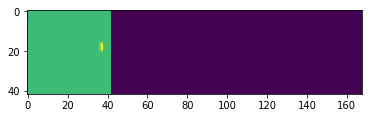

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
#plot first observation. Only one frame
plt.imshow(s.swapaxes(1,2).reshape(-1,s.shape[-1]).T)

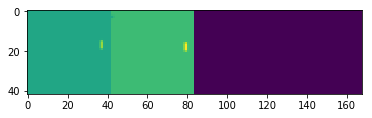

In [6]:
#next frame
new_s,r,done, _ = env.step(env.action_space.sample())
plt.imshow(new_s.swapaxes(1,2).reshape(-1,s.shape[-1]).T)

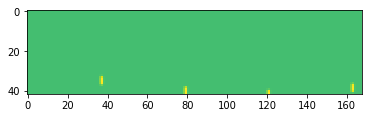

In [7]:
#after 10 frames
for _ in range(10):
    new_s,r,done, _ = env.step(env.action_space.sample())

plt.imshow(new_s.swapaxes(1,2).reshape(-1,s.shape[-1]).T,vmin=0)

In [92]:
"""solver = EvolutionStrategy()

while True:

  # ask the ES to give us a set of candidate solutions
  solutions = solver.ask()

  # create an array to hold the fitness results.
  fitness_list = np.zeros(solver.popsize)

  # evaluate the fitness for each given solution.
  for i in range(solver.popsize):
    fitness_list[i] = evaluate(solutions[i])

  # give list of fitness results back to ES
  solver.tell(fitness_list)

  # get best parameter, fitness from ES
  best_solution, best_fitness = solver.result()

  if best_fitness > MY_REQUIRED_FITNESS:
    break
"""

from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(8,8),   # Weight matrix : (7056, 8) -> (8, 8) -> (8, 6)
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )
#initialize agent to the dimension of state an amount of actions
agent.fit([env.reset().flatten()] * n_actions, range(n_actions));

In [98]:
def generate_coefs():
    layer_1_coef = np.random.rand(7056, 8)
    layer_2_coef = np.random.rand(8, 8)
    layer_3_coef = np.random.rand(8, 6)
    
    return [layer_1_coef, layer_2_coef, layer_3_coef]

In [101]:
def generate_bias():
    layer_1_bias = np.random.rand(8)
    layer_2_bias = np.random.rand(8)
    layer_3_bias = np.random.rand(6)
    
    return [layer_1_bias, layer_2_bias, layer_3_bias]

In [104]:
coefs_generated = [generate_coefs() for _ in range(50)]
bias_generated = [generate_bias() for _ in range(50)]
index_solutions = 0

In [105]:
class MLPClassifierOverride(MLPClassifier):
    def _initialize(self, y, layer_units):
        # set all attributes, allocate weights etc for first call
        # Initialize parameters
        self.n_iter_ = 0
        self.t_ = 0
        self.n_outputs_ = y.shape[1]

        # Compute the number of layers
        self.n_layers_ = len(layer_units)

        # Output for regression
        if not is_classifier(self):
            self.out_activation_ = 'identity'
        # Output for multi class
        elif self._label_binarizer.y_type_ == 'multiclass':
            self.out_activation_ = 'softmax'
        # Output for binary class and multi-label
        else:
            self.out_activation_ = 'logistic'

        # Initialize coefficient and intercept layers
        self.coefs_ = coefs_generated[index_solutions]
        self.intercepts_ = bias_generated[index_solutions]

        for i in range(self.n_layers_ - 1):
            coef_init, intercept_init = self._init_coef(layer_units[i],
                                                        layer_units[i + 1])
            self.coefs_.append(coef_init)
            self.intercepts_.append(intercept_init)

        if self.solver in _STOCHASTIC_SOLVERS:
            self.loss_curve_ = []
            self._no_improvement_count = 0
            if self.early_stopping:
                self.validation_scores_ = []
                self.best_validation_score_ = -np.inf
            else:
                self.best_loss_ = np.inf

In [148]:
def play_game(t_max = 100):
    """
    plays a game and returns reward and parameters
    """
    s = [env.reset().flatten()]
    total_reward = 0
    
    for t in range(t_max):
        
        #predict array of action probabilities
        probs = agent.predict_proba(s)[0] 
        
        a = np.random.choice(np.asarray(range(n_actions)), p=probs)#<sample action with such probabilities>
        
        new_s,r,done,info = env.step(a)
        new_s = [new_s.flatten()]
        #record sessions like you did before
        total_reward+=r
        
        s = new_s
        if done: break         
    return total_reward, agent.coefs_, agent.intercepts_

In [172]:
from IPython.display import clear_output

def select_best_n_solutions(samples_returned_number = 2, max_timesteps = 500):
    """ 100 timesteps ~= reward between -1.5 and 1.5)"""
    rewards_list = []
    bias_list = []
    coefs_list = []
    maximas_list = []
    returned_coefs = []
    returned_bias = []
    global index_solutions
    
    for i in bias_generated:
        agent = MLPClassifier(hidden_layer_sizes=(8,8),   # Weight matrix : (7056, 8) -> (8, 8) -> (8, 6)
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )
        
        print ("generating solution number " + str(index_solutions))
        agent.fit([env.reset().flatten()] * n_actions, range(n_actions));
        index_solutions += 1
        reward, coefs, bias = play_game(max_timesteps)
        clear_output()
        
        rewards_list.append(reward)
        coefs_list.append(coefs)
        bias_list.append(bias)
        print ("rewards list : " + str(rewards_list))
    
    for i in range(samples_returned_number):
        maximum_index = rewards_list.index(max(rewards_list)) # getting the index of the best parameters
        rewards_list.remove(max(rewards_list))                # removing the best parameter from the rewards_list
        maximas_list.append(maximum_index)                   # maximums_list contains the index of the maximas
    
    for i in maximas_list:
        returned_coefs.append(coefs_list[i])
        returned_bias.append(bias_list[i])
    
    print ("Maximum rewards'index : " + str(maximas_list))
    return returned_coefs, returned_bias

In [173]:
max_generation = 50
coefs_generated = [generate_coefs() for _ in range(max_generation)]
bias_generated = [generate_bias() for _ in range(max_generation)]
index_solutions = 0
coefs_computed, bias_computed = select_best_n_solutions()

rewards list : [-10.0, -11.0, -10.0, -11.0, -13.0, -4.0, -11.0, -10.0, -10.0]
generating solution number 9


KeyboardInterrupt: 

(2, 3)
